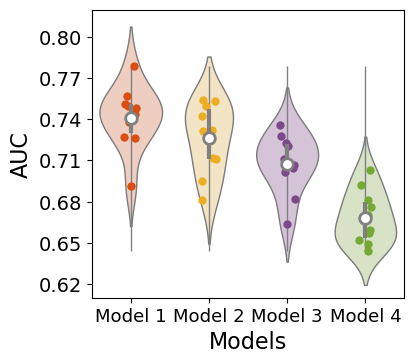

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file with date parsing for time columns
df = pd.read_csv(
    '../data/all_AR+ST+ET+event+Prot+Met+Pop.csv',
    parse_dates=['start_time', 'end_time']
)

# Calculate duration in years and filter records <= 5 years
df['duration_years'] = (df['end_time'] - df['start_time']).dt.days / 365.25
df_filtered = df[df['duration_years'] <= 5].copy()

# Target Variable Preparation
y = df_filtered['event']

# Define feature ranges and LightGBM parameters for each model
models_params = [
    ([3, 309], {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.01, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1}),
    ([3, 308], {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 2, 'learning_rate': 0.4, 'feature_fraction': 0.4, 'bagging_fraction': 0.4, 'bagging_freq': 5, 'verbose': -1}),
    ([3, 303], {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 5, 'learning_rate': 0.3, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 5, 'verbose': -1}),
    ([3, 301], {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 3, 'learning_rate': 0.7, 'feature_fraction': 0.4, 'bagging_fraction': 0.5, 'bagging_freq': 5, 'verbose': -1})
]

# Model identifiers
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# 10-fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store AUC results for each fold and model
auc_records = []

# Model Training and Evaluation
for model_name, (feat_range, params) in zip(model_names, models_params):
    X = df_filtered.iloc[:, feat_range[0]:feat_range[1]]

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = lgb.LGBMClassifier(**params, random_state=42)
        clf.fit(X_train, y_train)

        y_pred_prob = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_prob)

        auc_records.append({'Model': model_name, 'Fold': fold, 'AUC': auc})

# Convert results to DataFrame
auc_df = pd.DataFrame(auc_records)

# Visualization: Violin + Scatter Plot
plt.figure(figsize=(4.5, 4))

# Create violin plot showing distribution of AUC scores
ax = sns.violinplot(x='Model', y='AUC', data=auc_df, 
                   inner=None,
                   palette=['#F5CBBA', '#FAE7BC', '#D8BFDC', '#D8E6C3'],
                   linewidth=1)

# Define colors for scatter points
scatter_colors = ['#DA4E12', '#EEAE24', '#7C4A8A', '#74AA33']
model_order = model_names

# Add individual data points as scatter plot
for i, model in enumerate(model_order):
    model_data = auc_df[auc_df['Model'] == model]
    sns.stripplot(x='Model', y='AUC', data=model_data, jitter=True, size=6, 
                 color=scatter_colors[i], ax=ax)

# Add custom statistical markers
for i, model in enumerate(model_order):
    model_data = auc_df[auc_df['Model'] == model]['AUC']
    q1, median, q3 = np.percentile(model_data, [25, 50, 75])
    mean_auc = model_data.mean()

    # Add interquartile range line
    ax.vlines(i, ymin=q1, ymax=q3, color='grey', linestyle='-', linewidth=3, zorder=3)
    
    # Add central reference line
    ax.vlines(i, ymin=auc_df['AUC'].min(), ymax=auc_df['AUC'].max(), 
              color='gray', linestyle='solid', linewidth=1, zorder=1)
    
    # Mark mean value with hollow circle
    plt.scatter(i, mean_auc, facecolor='white', edgecolors='grey', 
                s=70, linewidths=2, zorder=5, label='Mean AUC' if i == 0 else "")

# Configure plot appearance
plt.ylim([0.61, 0.82])
plt.yticks(np.arange(0.62, 0.81, 0.03))
ax.set_xlim(-0.5, len(model_order)-0.5)

# Adjust tick label sizes
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=14)

# Add axis labels
plt.ylabel('AUC', fontsize=16)
plt.xlabel('Models', fontsize=16)

# Remove grid and adjust layout
plt.grid(False)
plt.tight_layout(pad=2.0)

# Display the plot
plt.show()